Дана база прослушанных композиций с сервиса Spotify с оценкой автора датасета (понравилась, не понравилась). Необходимо определить, понравится ли автору датасета та или иная музыкальная композиция.
https://www.kaggle.com/geomack/spotifyclassification

Признаки

- acousticness - количество акустики в звучании
- danceability - танцевальность
- duration_ms - длительность в миллисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - тональность
- liveness - количество "живой" записи
- loudness - громкость
- mode
- speechiness - количество речи
- tempo - темп
- time_signature
- valence
- song_title - название композиции
- artist - исполнитель


Целевой признак
- target - нравится ли композиция автору датасета (0, 1)


# 1. Подготовка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats as st
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from mlxtend.classifier import StackingClassifier
from joblib import dump, load
from IPython.display import display
import warnings

warnings.simplefilter("ignore") #будем игнорировать предупреждения
SEED = 42 #определяем константу, которая будет инициировать случайные числа

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Подключим гугл-диск:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Прочитаем данные и посмотрим на них:

In [3]:
data = pd.read_csv('/content/gdrive/My Drive/spotify2019/data.csv', encoding="iso-8859-1",index_col=0)
print(display(data.head()))
print(data.info())
print('Дубликатов:', data.duplicated().sum())
print(display(data.describe()))
    
for column in data:
    if data[column].dtype == 'object':
        print('Признак:', column)
        print('Уникальные:', data[column].value_counts().count())
        print()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  song_title        2017 non-null   object 
 15  artist            2017 non-null   object 
dtypes: float64(10), int64(4), object(2)
m

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


None
Признак: song_title
Уникальные: 1956

Признак: artist
Уникальные: 1343



Избавимся от дубликатов:

In [4]:
data= data.drop_duplicates().reset_index(drop=True)

Построим диаграмму отношений между всеми парами признаков:

In [5]:
plt.figure(figsize = (16,16))
sns.pairplot(data=data, hue="target")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Мы видим зависимость близкую к линейной между признаками `danceability`, `valence` и между признаками `loudness`, `energy`.

Посмотрим на корреляции нашего целевого признака с прочими признаками:

In [6]:
def ranking(y, title='', xlabel='', ylabel=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(5,5))
    cmap = ListedColormap(sns.color_palette("GnBu_d"))
    bar_colors = cmap(y.values)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(ch), xy=(ch if ch>0 else 0, p), va='center')

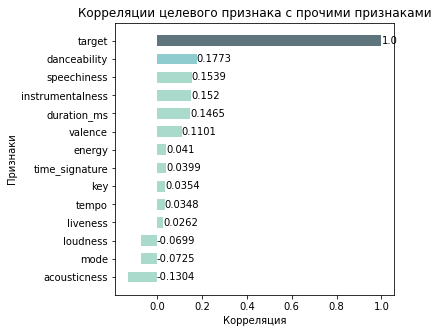

In [7]:
ranking(data.corr()['target'].sort_values(ascending = False), 'Корреляции целевого признака с прочими признаками', 'Корреляция', 'Признаки')

Сильных корреляций целевого признака с прочими признаками не наблюдается.

Поделим численные значения признаков на группы значений от...до...:

In [8]:
def range_col(data,parameter, begin, end, step):

  rangecol = []
  
  for row in data.values:
    row[parameter] = float(row[parameter])
    
    if row[parameter] < begin:
      rangecol.append("<" + str(round(begin,2)))
    elif row[parameter] >= end:
      rangecol.append(">=" + str(round(end,2)))
    else:
      for r in np.arange(begin,end,step).round(2):
        if r <= row[parameter] < min((r+step, end)):
          rangecol.append(str(round(r,2))+"-"+str(round(min(r+step, end),2)))
          break
        
  
     
  return rangecol

In [9]:
data_modified = data.copy()
data_modified['acousticness'] = range_col(data_modified, 0, 0, 1, 0.1)
data_modified['danceability'] = range_col(data_modified, 1, 0, 1, 0.1)
data_modified['duration_ms'] = range_col(data_modified, 2, 50000, 1000000, 50000)
data_modified['energy'] = range_col(data_modified, 3, 0, 1, 0.1)
data_modified['instrumentalness'] = range_col(data_modified, 4, 0, 1, 0.1)
data_modified['liveness'] = range_col(data_modified, 6, 0, 1, 0.1)
data_modified['loudness'] = range_col(data_modified, 7, -34, 0, 2)
data_modified['speechiness'] = range_col(data_modified, 9, 0, 1, 0.1)
data_modified['tempo'] = range_col(data_modified, 10, 40, 220, 10)
data_modified['valence'] = range_col(data_modified, 12, 0, 1, 0.1)

In [10]:
print(display(data_modified.head()))

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0-0.1,0.8-0.9,200000-250000,0.4-0.5,0.0-0.1,2,0.1-0.2,-10--8,1,0.4-0.5,150-160,4.0,0.2-0.3,1,Mask Off,Future
1,0.1-0.2,0.7-0.8,300000-350000,0.3-0.4,0.0-0.1,1,0.1-0.2,-12--10,1,0.0-0.1,160-170,4.0,0.5-0.6,1,Redbone,Childish Gambino
2,0.0-0.1,0.8-0.9,150000-200000,0.4-0.5,0.0-0.1,2,0.1-0.2,-8--6,1,0.2-0.3,70-80,4.0,0.1-0.2,1,Xanny Family,Future
3,0.6-0.7,0.4-0.5,150000-200000,0.3-0.4,0.5-0.6,5,0.0-0.1,-16--14,1,0.0-0.1,80-90,4.0,0.2-0.3,1,Master Of None,Beach House
4,0.1-0.2,0.6-0.7,350000-400000,0.5-0.6,0.5-0.6,5,0.4-0.5,-12--10,0,0.0-0.1,170-180,4.0,0.9-1.0,1,Parallel Lines,Junior Boys


None


Закодируем признаки при помощи `One-hot-encoder` (вместо строковых значений отдельные столбцы, где соответсвующий признак будет обозначаться нулем или единицей).

In [11]:
data_encoded = pd.get_dummies(data_modified.drop('song_title', axis = 1), dummy_na=False, drop_first=True)

print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Columns: 1456 entries, key to artist_íë«í Flat Feet
dtypes: float64(1), int64(3), uint8(1452)
memory usage: 2.8 MB
None


Разбьем последовательно выборки на тренировочную, валидационную и тестовую в соотношении `6:2:2` :

Сперва поделим наши данные на `features` (признаки) и `target` (целевой признак)

In [12]:
features = data_encoded.drop('target', axis =1)
target = data_encoded['target']

In [13]:
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size=0.20, random_state=SEED)
features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.25, random_state=SEED)
print(features_train.shape, features_val.shape, features_test.shape, target_train.shape, target_val.shape, target_test.shape)

(1206, 1455) (403, 1455) (403, 1455) (1206,) (403,) (403,)


Посмотрим, как распределяются классы в нашем целевом признаке:

In [14]:
target.value_counts(normalize = True)

1    0.504473
0    0.495527
Name: target, dtype: float64

Примерно 50% нулей и 50% единиц - 1:1. У нас сбалансированные классы.

### Вывод

- Мы импортировали необходимые библиотеки.
- Прочитали данные и изучили их.
- Избавились от дубликатов.
- Построили диаграмму отношений между всеми парами признаков. Мы видим зависимость близкую к линейной между признаками `danceability`, `valence` и между признаками `loudness`, `energy`.
- Изучили корреляции целевого признака с прочими признаками (сильных не наблюдается).
- Поделили численные значения признаков на группы значений от...до...
- Закодировали признаки при помощи One-hot-encoder (вместо строковых значений отдельные столбцы, где соответсвующий признак обозначается нулем или единицей).
- Разбили последовательно выборки на тренировочную, валидационную и тестовую в соотношении `6:2:2`.
- Посмотрели на распределение классов в целевом признаке (классы сбалансированы).

# 3. Обучение моделей

Попробуем применить следующие алгоритмы машинного обучения: логистическую регрессию, градиентный бустинг, ансамбль из предыдущих моделей (метамодель - логистическая регрессия). Будем искать лучшие параметры моделей. В качестве основной метрики будем использовать `roc_auc`, в качестве дополнительной - `accuracy_score`. Результаты соберем в таблицу, затем сравним их результаты и выберем лучшую модель. Построим кривые обучения для всех моделей.

In [15]:
clf1 = LogisticRegression(random_state = SEED)
clf2 = GradientBoostingClassifier(random_state = SEED)
lr = LogisticRegression(random_state = SEED)
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                          use_probas=True,
                          meta_classifier=lr)

In [16]:
param1 = ({'C': list(np.arange(1, 10)), 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},    
              {'C': list(np.arange(1, 10)), 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']})

param2 = ({'learning_rate': (0.01, 0.05, 0.1, 0.5),
                  'n_estimators': (50, 100, 200),
                  'min_samples_split': (2, 3),
                  'max_depth': (2, 3, 5)
                                                   
                 })
param_sclf = ({})

In [17]:
scorer = make_scorer(roc_auc_score)

Logistic Regression
{'C': 9, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy score = 0.7482
roc_auc = 0.8090

Gradient Boosting
{'learning_rate': 0.5, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
accuracy score = 0.7337
roc_auc = 0.8172

Stacking Classifier
{}
accuracy score = 0.7535
roc_auc = 0.8252



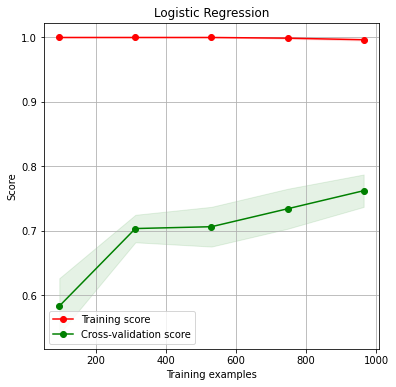

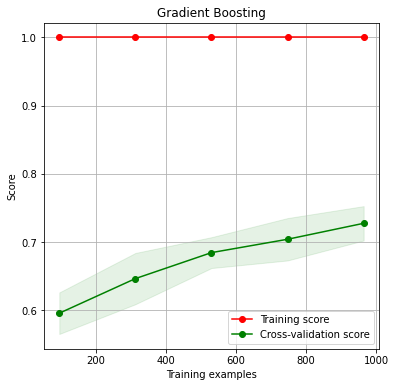

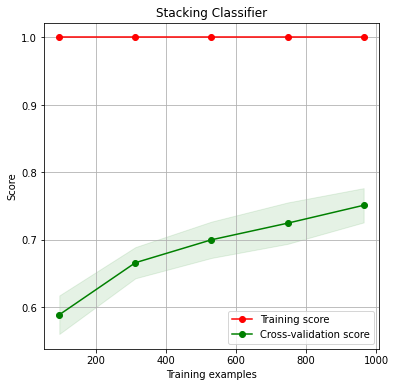

In [18]:
score_table = pd.DataFrame(columns = ['model', 'params', 'accuracy_score', 'roc_auc'])
i=0
for clf, label, param in zip([clf1, clf2,sclf], 
                      ['Logistic Regression', 
                       'Gradient Boosting',
                       'Stacking Classifier'], 
                       [param1, param2, param_sclf]):
    
    grid = model_selection.GridSearchCV(clf, param_grid=param,scoring=scorer)
    grid.fit(features_train, target_train)
    scores = grid.score(features_val, target_val)
    print(label)
    print(grid.best_params_)
    print("accuracy score = %0.4f" 
          % (scores))
    probabilities = grid.predict_proba(features_test)
    probabilities_ones = probabilities[:,1]
    auc_roc = roc_auc_score(target_test, probabilities_ones)
    print('roc_auc = {:0.4f}'.format(auc_roc)) 
    print()
    if clf == clf1:
      clf1.set_params(**grid.best_params_)
    if clf == clf2:
      clf2.set_params(**grid.best_params_)
    score_table.loc[i, 'model'] = label
    score_table.loc[i, 'params'] = [grid.best_params_]
    score_table.loc[i, 'accuracy_score'] = scores
    score_table.loc[i, 'roc_auc'] = auc_roc

    i+=1


    train_sizes, train_scores, test_scores, fit_times, _ = model_selection.learning_curve(clf, features_train, target_train, return_times=True, scoring=scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    _, axes = plt.subplots(1, 1, figsize=(6, 6))

    axes.set_title(label)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")    


Посмотрим на таблицу результатов и рейтинг по метрике `roc_auc`:

In [19]:
score_table

,model,params,accuracy_score,roc_auc
0,Logistic Regression,"[{'C': 9, 'multi_class': 'ovr', 'penalty': 'l2...",0.748176,0.808957
1,Gradient Boosting,"[{'learning_rate': 0.5, 'max_depth': 5, 'min_s...",0.733683,0.817189
2,Stacking Classifier,[{}],0.753549,0.8252


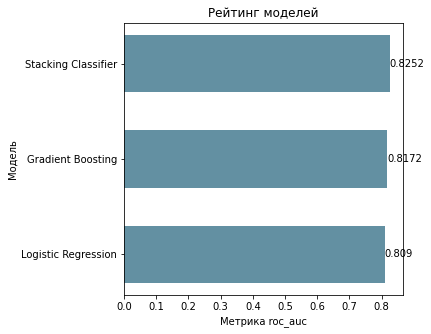

In [20]:
ranking(score_table.groupby(['model'])['roc_auc'].aggregate('max').sort_values(ascending = False), 'Рейтинг моделей', 'Метрика roc_auc', 'Модель')

Как видим, лучшее значение нашей основной метрики `roc_auc` - у ансамбля.

### Вывод

- Мы применили следующие алгоритмы машинного обучения: логистическую регрессию, градиентный бустинг, ансамбль из предыдущих моделей (метамодель - логистическая регрессия). 
- Нашли лучшие параметры моделей. В качестве основной метрики использовали `roc_auc`, в качестве дополнительной - `accuracy_score`. 
- Построили кривые обучения для всех моделей.
- Результаты собрали в таблицу, затем сравнили их результаты и выбрали лучшую модель - ансамбль. 

# 4. Тестирование модели

Проверим работу нашей лучшей модели - ансамбля на тестовых данных:

In [21]:
clf1 = LogisticRegression(random_state = SEED)
params = score_table[score_table['model']=='Logistic Regression']['params']
clf1.set_params(**params[0][0])

clf2 = GradientBoostingClassifier(random_state = SEED)
params = score_table[score_table['model']=='Gradient Boosting']['params']

clf2.set_params(**params[1][0])

lr = LogisticRegression(random_state = SEED)
model = StackingClassifier(classifiers=[clf1, clf2], 
                          use_probas=True,
                          meta_classifier=lr)
model.fit(features_train_val, target_train_val)

StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=9, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='ovr',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=42,
                                                   solver='lbfgs', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                GradientBoostingClassifier(ccp_alpha=0.0,
                                                           criterion='friedman_mse',...
         

In [22]:
target_predict = model.predict(features_test)
accuracy = accuracy_score(target_test, target_predict)
print('Best model:')
print("accuracy score = %0.4f" % (accuracy))
probabilities = model.predict_proba(features_test)
probabilities_ones = probabilities[:,1]
auc_roc = roc_auc_score(target_test, probabilities_ones)
print('roc_auc = {:0.4f}'.format(auc_roc))      


Best model:
accuracy score = 0.7667
roc_auc = 0.8373


Сравним результаты с константной моделью:

In [23]:
model_dummy = DummyClassifier()
model_dummy.fit(features_train_val, target_train_val)
target_predict_d = model_dummy.predict(features_test)
accuracy_d = accuracy_score(target_test, target_predict_d)
print('Dummy classifier:')
print("accuracy score = %0.4f" % (accuracy_d))
probabilities_d = model_dummy.predict_proba(features_test)
probabilities_ones_d = probabilities_d[:,1]
auc_roc_d = roc_auc_score(target_test, probabilities_ones_d)
print('roc_auc = {:0.4f}'.format(auc_roc_d))     


Dummy classifier:
accuracy score = 0.5161
roc_auc = 0.5124


Результаты работы нашей модели существенно лучше, чем константной.

Построим для лучшей и константной модели ROC-кривую, отобразим разные значения порогов:

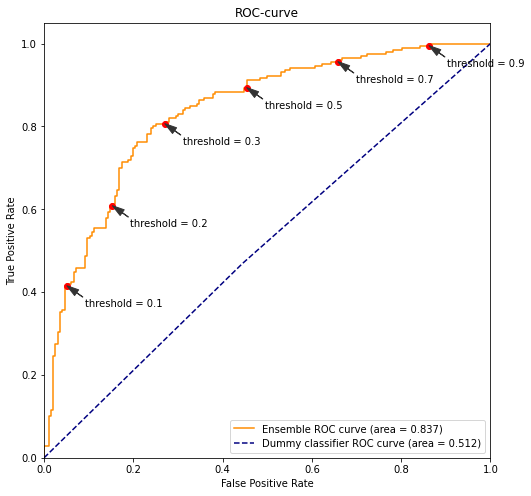

In [24]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_ones)
fpr_d, tpr_d, thresholds_d = roc_curve(target_test, probabilities_ones_d)
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color='darkorange', label='Ensemble ROC curve (area = %0.3f)' % auc_roc)

plt.plot(fpr_d, tpr_d, color='navy', linestyle='--', label = 'Dummy classifier ROC curve (area = %0.3f)' % auc_roc_d)


for point,flag in zip([0.10, 0.20, 0.30, 0.50, 0.70, 0.90], [0,0,0,0,0,0]):
  i=0
  for fp in fpr:
    if round(fp, 1) == point and flag ==0:
      plt.plot(fpr[i], tpr[i], color='red', marker="o")
      plt.annotate("threshold = {}".format(point), xy=(fpr[i], tpr[i]), xytext=(fpr[i]+0.04, tpr[i]-0.05),  arrowprops={'width':0.3,'headwidth':7,'color':'#333333'})
      flag=1
    i+=1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(loc="lower right")
plt.show()

Найдем оптимальный порог:

In [25]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold = %0.2f" %optimal_threshold)

Optimal threshold = 0.31


In [26]:
print('threshold = %0.2f' %optimal_threshold)
preds = [1 if pr>optimal_threshold else 0 for pr in probabilities_ones]
print("accuracy score = %0.4f" %(accuracy_score(target_test, preds)))

threshold = 0.31
accuracy score = 0.7767


Попробуем применить порог 0.25:

In [27]:
print('threshold =', 0.25)
preds = [1 if pr>0.25 else 0 for pr in probabilities_ones]
print("accuracy score = %0.4f" %(accuracy_score(target_test, preds)))

threshold = 0.25
accuracy score = 0.7792


<a id='section41'></a>

### Вывод

- Мы проверили работу нашей лучшей модели - ансамбля на тестовых данных. Получили `roc_auc = 0.8380` и `accuracy score = 0.7692`.
- Сравнили результаты с константной моделью. Полученные нами результаты значительно лучше результатов работы константной модели.
- Построили для лучшей и константной модели ROC-кривую, отобразили разные значения порогов.
- Нашли оптимальное значение порога, нашли `accuracy score` для оптимального значения порога и для порога 0.25.


# 5. Общий вывод

- Мы импортировали необходимые библиотеки.
- Прочитали данные и изучили их.
- Избавились от дубликатов.
- Построили диаграмму отношений между всеми парами признаков. Мы видим зависимость близкую к линейной между признаками `danceability`, `valence` и между признаками `loudness`, `energy`.
- Изучили корреляции целевого признака с прочими признаками (сильных не наблюдается).
- Поделили численные значения признаков на группы значений от...до...
- Закодировали признаки при помощи One-hot-encoder (вместо строковых значений отдельные столбцы, где соответсвующий признак обозначается нулем или единицей).
- Разбили последовательно выборки на тренировочную, валидационную и тестовую в соотношении `6:2:2`.
- Посмотрели на распределение классов в целевом признаке (классы сбалансированы).
- Мы применили следующие алгоритмы машинного обучения: логистическую регрессию, градиентный бустинг, ансамбль из предыдущих моделей (метамодель - логистическая регрессия). 
- Нашли лучшие параметры моделей. В качестве основной метрики использовали `roc_auc`, в качестве дополнительной - `accuracy_score`. 
- Построили кривые обучения для всех моделей.
- Результаты собрали в таблицу, затем сравнили их результаты и выбрали лучшую модель - ансамбль. 
- Мы проверили работу нашей лучшей модели - ансамбля на тестовых данных. Получили `roc_auc = 0.8380` и `accuracy score = 0.7692`.
- Сравнили результаты с константной моделью. Полученные нами результаты значительно лучше результатов работы константной модели.
- Построили для лучшей и константной модели ROC-кривую, отобразили разные значения порогов.
- Нашли оптимальное значение порога, нашли `accuracy score` для оптимального значения порога и для порога 0.25.
